In [1]:
import os

import numpy as np
import math
import uproot as uproot
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import gridspec
import dunestyle.matplotlib as dunestyle

import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import median_abs_deviation
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
import scipy.linalg as la
import scipy.optimize as opt
from scipy.optimize import Bounds, LinearConstraint
from scipy.stats import chisquare

from landaupy import langauss

from branches import *
from pandas_helpers import *

DUNE plot style enabled


In [2]:
PDG = {
    "muon": [13, "muon", 0.105,],
    "proton": [2212, "proton", 0.938272,], 
    "neutron": [2112, "neutron", 0.9395654,], 
    "pizero": [111, "pizero", 0.1349768], 
    "piplus": [211, "piplus", 0.13957039], 
    "piminus": [-211, "piminus", 0.13957039], 
    "argon": [1000180400, "argon", (18*0.938272 + 22*0.9395654)], 
    "gamma": [22, "gamma", 0 ], 
    "lambda": [3122, "lambda", 1.115683], 
    "kaon_p": [321, "kaon_p",  0.493677], 
    "sigma_p": [3222, "sigma_p", 1.18936], 
    "kaon_0": [311, "kaon_0", 0.497648], 
    "sigma_0": [3212, "sigma_0", 1.19246], 
    "lambda_p_c": [4122, "lambda_p_c", 2.28646], 
    "sigma_pp_c": [4222, "sigma_pp_c", 2.45397], 
    "electron": [11, "electron", 0.510998950], 
    "sigma_p_c": [4212, "sigma_p_c", 2.4529],
}

THRESHOLD = {"muon": 0.175, "proton": 0.3, "proton_stub": 0.2, "picharged": 0.07, "pizero":0}

In [3]:
def InFV(data): # cm
    xmin = -199.15 + 10
    ymin = -200. + 10
    zmin = 0.0 + 10
    xmax = 199.15 - 10
    ymax =  200. - 10
    zmax =  500. - 50
    return (data.x > xmin) & (data.x < xmax) & (data.y > ymin) & (data.y < ymax) & (data.z > zmin) & (data.z < zmax)

def InBeam(t):
    return (t > 0.) & (t < 1.800)

def Avg(df, pid, drop_0=True):  # average score of 3 planes, exclude value if 0
    if drop_0:
        df = df.replace(0, np.nan)
    average = df[[("chi2pid", "I0", "chi2_"+pid), ("chi2pid", "I1", "chi2_"+pid), ("chi2pid", "I2", "chi2_"+pid)]].mean(skipna=drop_0, axis=1)
    return average

def Signal(df): # signal definition
    is_fv = InFV(df.nu.position)
    is_numu = (df.nu.pdg == 14)
    is_cc = (df.nu.iscc == 1)
    is_1p0pi = (df.mult_proton_def == 1) & (df.mult_picharged_def == 0) & (df.mult_pizero == 0)
    return is_fv & is_numu & is_cc # & is_1p0pi

In [4]:
fname = '/Users/sungbino/Study/FNAL/SBND/data/flatcaf/2023B/GENIE_CV/caf.flat.caf-993b3810-d027-402c-8486-f42abb1b0bd3.root'
events = uproot.open(fname+":recTree")

In [5]:
# MC truth
nudf = loadbranches(events, mc_branches)
nudf = nudf.rec.mc

nuprimdf = loadbranches(events, mc_prim_branches)
nuprimdf = nuprimdf.rec.mc.nu
nuprimdf[("prim","totp","")] = np.sqrt((nuprimdf.prim.startp.x)**2+(nuprimdf.prim.startp.y)**2+(nuprimdf.prim.startp.z)**2) # |momentum| branch

# primary track multiplicity
mult_muon = (nuprimdf.prim.pdg == 13).groupby(level=[0,1]).sum()
mult_muon_def = ((nuprimdf.prim.pdg == 13) & (nuprimdf.prim.totp > THRESHOLD["muon"])).groupby(level=[0,1]).sum()
mult_proton = (nuprimdf.prim.pdg == 2212).groupby(level=[0,1]).sum()
mult_proton_def = ((nuprimdf.prim.pdg == 2212) & (nuprimdf.prim.totp > THRESHOLD["proton"])).groupby(level=[0,1]).sum()
mult_proton_stub_def = ((nuprimdf.prim.pdg == 2212) & (nuprimdf.prim.totp > THRESHOLD["proton_stub"])).groupby(level=[0,1]).sum()
mult_picharged = (np.abs(nuprimdf.prim.pdg) == 211).groupby(level=[0,1]).sum()
mult_picharged_def = ((np.abs(nuprimdf.prim.pdg) == 211) & (nuprimdf.prim.totp > THRESHOLD["picharged"])).groupby(level=[0,1]).sum()
mult_pizero = (np.abs(nuprimdf.prim.pdg) == 211).groupby(level=[0,1]).sum()
mult_pizero_def = ((np.abs(nuprimdf.prim.pdg) == 111) & (nuprimdf.prim.totp > THRESHOLD["pizero"])).groupby(level=[0,1]).sum()
mult_electron = (nuprimdf.prim.pdg == 11).groupby(level=[0,1]).sum()
mult_photon = (nuprimdf.prim.pdg == 22).groupby(level=[0,1]).sum()
nudf['mult_muon'] = mult_muon
nudf['mult_muon_def'] = mult_muon_def
nudf['mult_proton'] = mult_proton
nudf['mult_proton_def'] = mult_proton_def
nudf['mult_proton_stub_def'] = mult_proton_stub_def
nudf['mult_picharged'] = mult_picharged
nudf['mult_picharged_def'] = mult_picharged_def
nudf['mult_pizero'] = mult_pizero
nudf['mult_pizero_def'] = mult_pizero_def
nudf['mult_electron'] = mult_electron
nudf['mult_photon'] = mult_photon

# truth match
slcdf = loadbranches(events, slc_branches)
slcdf = slcdf.rec

slcdf.loc[np.invert(slcdf[("slc","tmatch","eff")] > 0.5) & (slcdf[("slc","tmatch","idx")] >= 0), ("slc","tmatch","idx")] = np.nan
slcdf["tmatch_index"] = slcdf[("slc", "tmatch", "idx")]

matchdf = pd.merge(slcdf.reset_index(), 
                 nudf.reset_index(),
                 left_on=[("entry", "",""), ("slc","tmatch", "idx")], # entry index -> neutrino index
                 right_on=[("entry", "",""), ("rec.mc.nu..index", "","")], 
                 how="left", # Keep every slc
                 )

matchdf = matchdf.set_index(["entry", "rec.slc..index"], verify_integrity=True)

/opt/homebrew/Caskroom/miniconda/base/envs/moon_git/lib/python3.10/site-packages/pandas/core/series.py:872: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)
/opt/homebrew/Caskroom/miniconda/base/envs/moon_git/lib/python3.10/site-packages/pandas/core/series.py:872: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)


In [6]:
# reco pfps
pfptrkdf = loadbranches(events, pfp_trk_branches)
pfptrkdf = pfptrkdf.rec.slc.reco.pfp

pfptrkchi2df = loadbranches(events, pfp_trk_chi2_branches)
pfptrkchi2df = pfptrkchi2df.rec.slc.reco.pfp.trk

pfptrkdf = pfptrkdf.join(pfptrkchi2df)

pfptruthdf = loadbranches(events, pfp_trk_mc_branches)
pfptruthdf = pfptruthdf.rec.slc.reco.pfp.trk.truth

pfpdf = pd.merge(pfptrkdf, pfptruthdf, left_index=True, right_index=True, how="inner")

pandoradf = loadbranches(events, pandora_branches)
pandoradf = pandoradf.rec.slc

pfpdf = pd.merge(pfpdf, pandoradf, left_index=True, right_index=True, how="inner")

# merge all
masterdf = pd.merge(matchdf, pfpdf, left_index=True, right_index=True, how="inner")

## reco pfp track hits
pfptrkhit0df = loadbranches(events, pfp_trk_hit0_branches)
pfptrkhit1df = loadbranches(events, pfp_trk_hit1_branches)
pfptrkhit2df = loadbranches(events, pfp_trk_hit2_branches)
pfptrkhit0df = pfptrkhit0df.rec.slc.reco.pfp.trk.calo.I0.points
pfptrkhit1df = pfptrkhit1df.rec.slc.reco.pfp.trk.calo.I1.points
pfptrkhit2df = pfptrkhit2df.rec.slc.reco.pfp.trk.calo.I2.points
hit_branches = pfptrkhit0df.columns.tolist()

pfptrkhit0df.index.set_names("rec.slc.reco.pfp.trk.calo.points..index", level="rec.slc.reco.pfp.trk.calo.0.points..index", inplace=True)
pfptrkhit1df.index.set_names("rec.slc.reco.pfp.trk.calo.points..index", level="rec.slc.reco.pfp.trk.calo.1.points..index", inplace=True)
pfptrkhit2df.index.set_names("rec.slc.reco.pfp.trk.calo.points..index", level="rec.slc.reco.pfp.trk.calo.2.points..index", inplace=True)

/opt/homebrew/Caskroom/miniconda/base/envs/moon_git/lib/python3.10/site-packages/pandas/core/series.py:872: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)
/opt/homebrew/Caskroom/miniconda/base/envs/moon_git/lib/python3.10/site-packages/pandas/core/series.py:872: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)
/opt/homebrew/Caskroom/miniconda/base/envs/moon_git/lib/python3.10/site-packages/pandas/core/series.py:872: RuntimeWarning: invalid value encountered in cast
  return np.asarray(self._values, dtype)


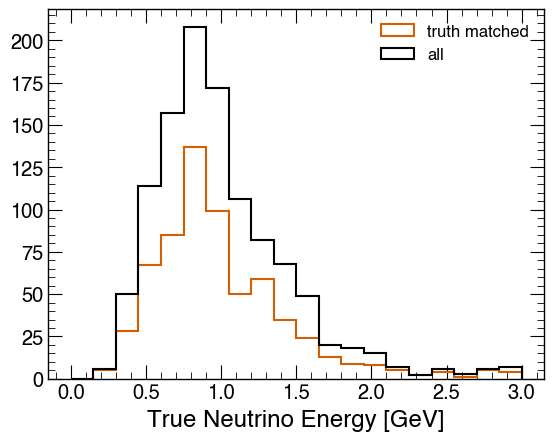

In [7]:
# truth match efficiency
nu_idx = matchdf.reset_index().set_index(["entry", "rec.mc.nu..index"]).index.unique()

nu_idx = [idx for idx in nu_idx if not math.isnan(idx[1])]

nudf_tmatched = nudf.loc[nu_idx]
var = [nudf[Signal(nudf)].nu.E, nudf_tmatched[Signal(nudf_tmatched)].nu.E]
plt.hist(var, bins=np.linspace(0,3,21), histtype="step", label=["all", "truth matched"])
plt.xlabel("True Neutrino Energy [GeV]")
plt.legend()
plt.show();

In [8]:
# reco vertex in FV
cut = InFV(masterdf.slc.vertex)
df_vertexcut = masterdf[cut]

In [9]:
# cosmic rejection
cut_nuscore = (df_vertexcut.slc.nu_score.squeeze() > 0.4)
cut_fmatch = ((df_vertexcut.slc.fmatch.score < 7.0) & (InBeam(df_vertexcut.slc.fmatch.time)))
df_cosmiccut = df_vertexcut[cut_nuscore & cut_fmatch]

In [10]:
# Long muon selection
MUCUT_LEN_THRES = 100
cut_len = (df_cosmiccut.trk.len > MUCUT_LEN_THRES)
primary_muons = df_cosmiccut[cut_len]
primary_muons = primary_muons.sort_values(["entry", "rec.slc..index", ("trk","len","")], ascending=[True, True, False])
leading_muon = primary_muons.groupby(["entry", "rec.slc..index"]).head(1) 
slc_idx_1mu = leading_muon.reset_index().set_index(["entry", "rec.slc..index"]).index.unique()
df_1mucut = df_cosmiccut.reset_index().set_index(["entry", "rec.slc..index"]).loc[slc_idx_1mu]
df_1mucut = df_1mucut.reset_index().set_index(["entry", "rec.slc..index", "rec.slc.reco.pfp..index"], verify_integrity=True)

In [11]:
leading_muon[('trk')]

start              \
                                                       x           y   
entry rec.slc..index rec.slc.reco.pfp..index                           
2     0              0                         38.723175  129.974258   
4     3              0                        188.153412   33.120438   
11    3              0                         64.359940  134.014099   
13    1              0                         20.151512   61.642982   
18    1              0                        -98.596870    4.676665   
...                                                  ...         ...   
2574  0              0                        160.259537  137.867615   
2577  0              0                        -27.217136  163.527283   
2583  1              0                       -140.688141 -102.988747   
2586  0              0                        -73.741364  -78.136902   
2587  1              0                         57.472519    5.465563   

                                                                 end  \
                                                       z           x   
entry rec.slc..index rec.slc.reco.pfp..index                           
2     0              0                        267.876678  -25.193956   
4     3              0                        236.678955  191.335724   
11    3              0                        334.605286  168.616196   
13    1              0                         63.987602   68.987122   
18    1              0                         56.158226 -110.064583   
...                                                  ...         ...   
2574  0              0                        314.789093  185.226349   
2577  0              0                        232.125504  139.093994   
2583  1              0                        111.213257 -201.100418   
2586  0              0                        176.663513 -200.952835   
2587  1              0                        259.130096   -5.116018   

                                                                      \
                                                       y           z   
entry rec.slc..index rec.slc.reco.pfp..index                           
2     0              0                        203.012863  318.424316   
4     3              0                         51.797577  332.237274   
11    3              0                        194.136749  436.737671   
13    1              0                       -113.796608   46.012249   
18    1              0                       -136.474304   83.642212   
...                                                  ...         ...   
2574  0              0                         97.148323  504.273010   
2577  0              0                        146.194183  355.583252   
2583  1              0                       -152.764359  324.188965   
2586  0              0                         46.734161  214.816940   
2587  1              0                        -70.540726  479.028717   

                                                   dir                      \
                                                     x         y         z   
entry rec.slc..index rec.slc.reco.pfp..index                                 
2     0              0                       -0.540067  0.699246  0.468382   
4     3              0                       -0.150116  0.624405  0.766540   
11    3              0                        0.659108  0.358059  0.661340   
13    1              0                        0.230210 -0.971872 -0.049675   
18    1              0                       -0.084915 -0.675589  0.732372   
...                                                ...       ...       ...   
2574  0              0                        0.125318 -0.208523  0.969955   
2577  0              0                        0.797705 -0.001862  0.603045   
2583  1              0                       -0.221878 -0.287407  0.931755   
2586  0              0                       -0.638636  0.749041  0.176301   
2587  1   

In [12]:
# Contained muon selection
#cut_contained = (InFV(df_1mucut[('trk', 'start')])) & InFV(df_1mucut[('trk', 'end')])
cut_contained = (InFV(leading_muon[('trk', 'start')])) & InFV(leading_muon[('trk', 'end')])
df_contained_muon = leading_muon[cut_contained]

/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_7657/3389193756.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  cut_contained = (InFV(leading_muon[('trk', 'start')])) & InFV(leading_muon[('trk', 'end')])


In [13]:
hit0_sel_df = pd.merge(pfptrkhit0df.reset_index(), df_contained_muon.reset_index(),
                        left_on=[("entry"), ("rec.slc..index"), ("rec.slc.reco.pfp..index")],
                        right_on=[("entry"), ("rec.slc..index"), ("rec.slc.reco.pfp..index")], 
                        how="inner",
                        )

hit1_sel_df = pd.merge(pfptrkhit1df.reset_index(), df_contained_muon.reset_index(),
                        left_on=[("entry"), ("rec.slc..index"), ("rec.slc.reco.pfp..index")],
                        right_on=[("entry"), ("rec.slc..index"), ("rec.slc.reco.pfp..index")], 
                        how="inner",
                        )

hit2_sel_df = pd.merge(pfptrkhit2df.reset_index(), df_contained_muon.reset_index(),
                        left_on=[("entry"), ("rec.slc..index"), ("rec.slc.reco.pfp..index")],
                        right_on=[("entry"), ("rec.slc..index"), ("rec.slc.reco.pfp..index")], 
                        how="inner",
                        )

/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_7657/3280358891.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 3 on the right)
  hit0_sel_df = pd.merge(pfptrkhit0df.reset_index(), df_contained_muon.reset_index(),
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_7657/3280358891.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  hit0_sel_df = pd.merge(pfptrkhit0df.reset_index(), df_contained_muon.reset_index(),
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_7657/3280358891.py:7: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 3 on the right)
  hit1_sel_df = pd.merge(pfptrkhit1df.reset_index(), df_contained_muon.reset_index(),
/var/folders/tj/3kjxrxwx2c37zmf4n9j5yh900000gq/T/ipykernel_7657/3280358891.py:7: PerformanceWarning: drop

In [14]:
#hit0_sel_df = hit0_sel_df.set_index(["entry", "rec.slc..index", "rec.slc.reco.pfp..index", "rec.slc.reco.pfp.trk.calo.points..index"], verify_integrity=True)[hit_branches]
#hit1_sel_df = hit1_sel_df.set_index(["entry", "rec.slc..index", "rec.slc.reco.pfp..index", "rec.slc.reco.pfp.trk.calo.points..index"], verify_integrity=True)[hit_branches]
#hit2_sel_df = hit2_sel_df.set_index(["entry", "rec.slc..index", "rec.slc.reco.pfp..index", "rec.slc.reco.pfp.trk.calo.points..index"], verify_integrity=True)[hit_branches]
hit0_sel_df = hit0_sel_df[hit_branches]
hit1_sel_df = hit1_sel_df[hit_branches]
hit2_sel_df = hit2_sel_df[hit_branches]



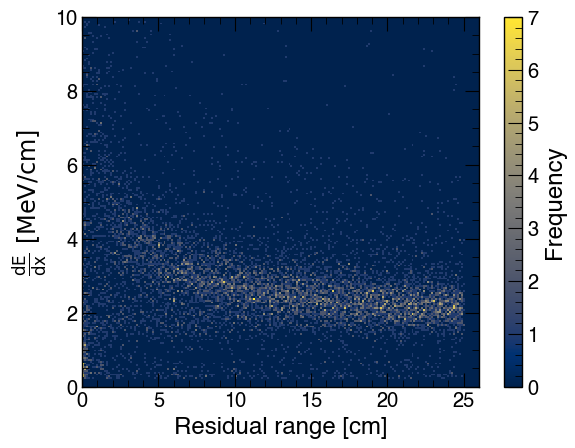

In [15]:
plt.hist2d(hit0_sel_df['rr'], hit0_sel_df['dedx'], bins=200, range = [[0, 26],[0,10]])
plt.colorbar(label='Frequency')
plt.xlabel('Residual range [cm]')
plt.ylabel(r'$\mathrm{\frac{dE}{dx}~[MeV/cm]}$')
#plt.savefig('./life_time/plots_2d/t_drift_vs_dqdx.pdf')
plt.show()

In [33]:
# Fitting for residual range slices
import numpy as np
from landaupy import langauss
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit

def binned_fit_langauss(x, y, y_err):
	area_guess = np.sum(y) * 0.05 / (x[1] - x[0])
	landau_x_mpv_guess = x[np.argmax(y)]
	landau_xi_guess = 0.1
	gauss_sigma_guess = 0.1
	print(area_guess)
	popt, pcov = curve_fit(
		lambda x, area, mpv, xi, g_sigma: area * langauss.pdf(x, mpv, xi, g_sigma),
		xdata = x,
		ydata = y,
		sigma = y_err,
		p0 = [area_guess, landau_x_mpv_guess, landau_xi_guess, gauss_sigma_guess],
	)
	return popt, pcov

def langau_func(x, area, mpv, xi, g_sigma):
    return area * langauss.pdf(x, mpv, xi, g_sigma)

def rr_to_str(rr):
    rr_str = ""
    if(rr < 10):
        rr_str = "0"
        rr_str = rr_str + format(rr, '.2f') + "cm"
    else:
        rr_str = format(rr, '.2f') + "cm"
    return rr_str

def rr_vs_dedx_langau(hitdf, prefix, suffix):
    rr_min = 3.0
    rr_max = 25.0
    rr_step = 1.0
    this_hitdf = hitdf
    this_hitdf['rr_bins'] = pd.cut(this_hitdf['rr'], bins=np.arange(rr_min, rr_max + rr_step, rr_step))
    rr_group_df = this_hitdf.groupby('rr_bins')

    for i, (group_name, group_data) in enumerate(rr_group_df):
        rr_low = rr_min + rr_step * i
        rr_high = rr_min + rr_step * (i + 1)
        this_file_name = './lplots/rr_vs_dedx/1d/' + prefix + 'dedx_' + rr_to_str(rr_low) + 'to' + rr_to_str(rr_high) + suffix + '.pdf'
    
        y, bin_edges = np.histogram(group_data['dedx'], bins=50, range = (0., 10.))
        bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
        mask = np.nonzero(y)
        
        fig, ax = plt.subplots()        
        plt.errorbar(
            x = bin_centers[mask],
            y = y[mask],
            yerr = y[mask]**0.5,
            linewidth=2, capsize=1,
            fmt='ok',
            drawstyle = 'default'
        )
        plt.title(' ')
        #plt.title(f'Residual range : {group_name} [cm]')
        plt.xlabel(r'$\mathrm{\frac{dE}{dx}~[MeV/cm]}$')
        plt.ylabel('Entries')
        ax.set_ylim(bottom=0)
        
        popt, pcov = binned_fit_langauss(bin_centers[mask], y[mask], y[mask]**0.5)
        print(popt)
        
        plt.plot(bin_centers, langau_func(bin_centers, *popt), 'r-', label='area=%5.2f\nMPV=%5.2f\nsigma_L=%5.2f\nsigma_G=%5.2f' % tuple(popt))

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.0)
        ax.text(0.65, 0.95, f'Residual range\n{group_name} [cm]', transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
        fit_result_str = r'$\mathrm{\frac{dE}{dx}~[MeV/cm]}$'
        ax.text(0.65, 0.95, f'Residual range\n{group_name} [cm]', transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
        plt.legend(loc=(0.6, 0.6))
        plt.show()

        #if i > 10:
        #    break

85.50000509619744
[61.11822109  3.49447815  0.06320109  1.12773694]


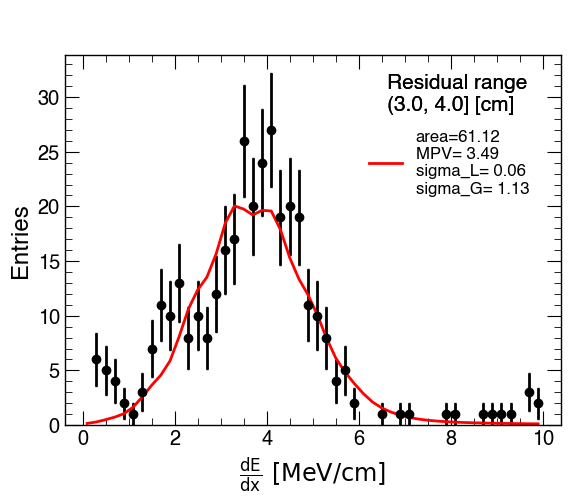

85.50000509619744
[5.58265218e+01 3.39900475e+00 3.65972825e-02 8.37451896e-01]


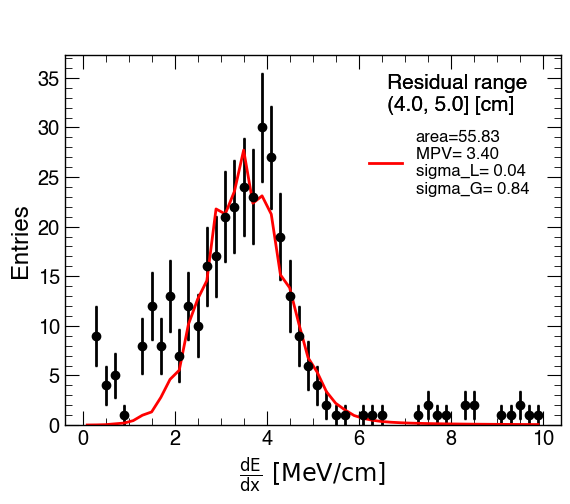

89.00000530481371
[63.59960578  2.79191718  0.11957384  0.90223879]


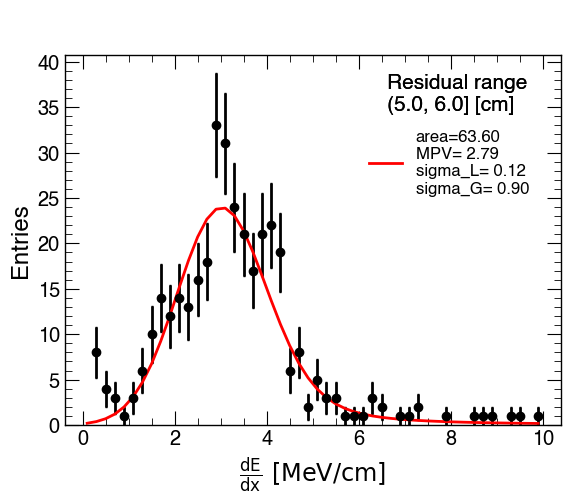

89.50000533461603
[5.89532442e+01 2.92198294e+00 3.19634385e-02 8.68596322e-01]


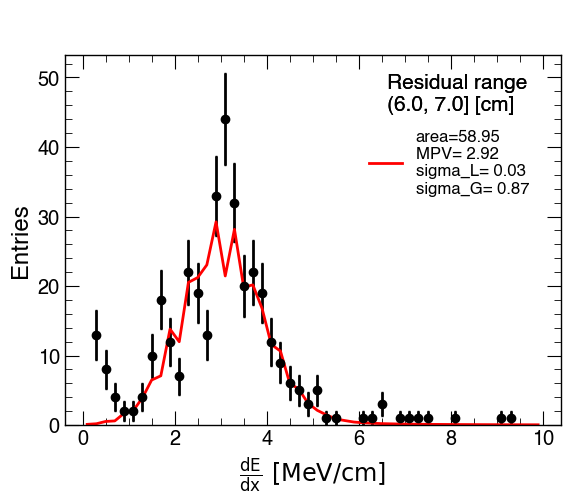

89.75000534951718
[6.46533173e+01 2.67527887e+00 2.15385387e-02 7.32370164e-01]


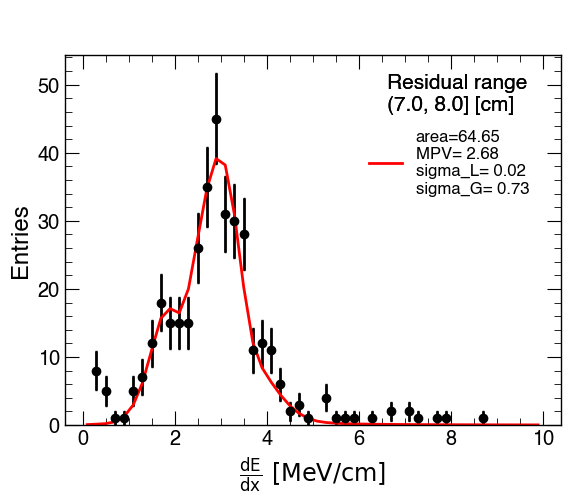

83.25000496208699
[63.29118363  2.51740526  0.10700424  0.66347637]


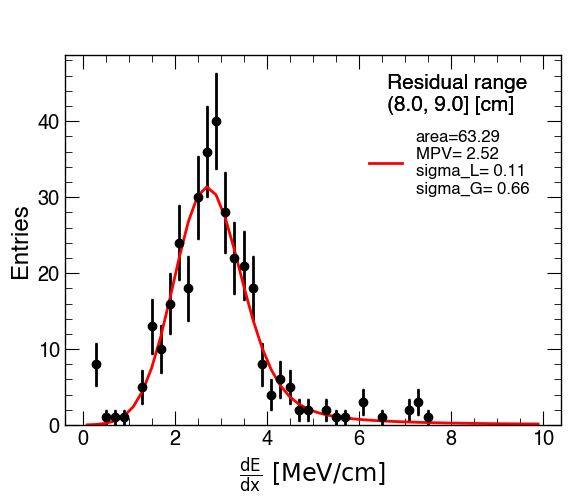

88.00000524520907
[59.77462791  2.46900468  0.07692871  0.62086261]


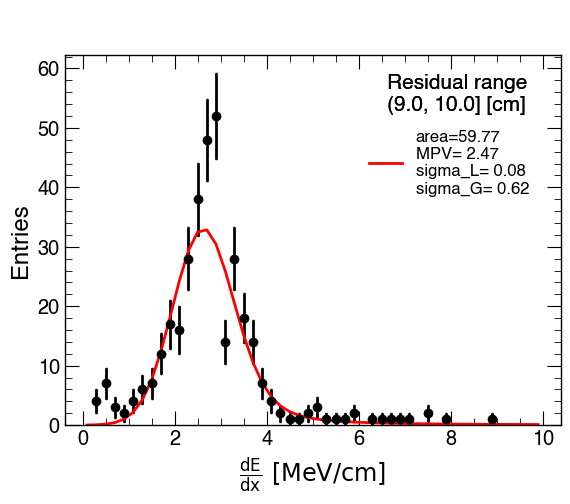

83.7500049918893
[60.88277153  2.42126065  0.09857266  0.4975197 ]


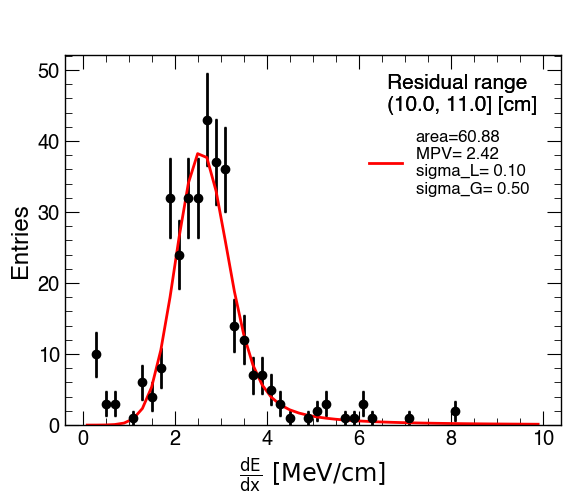

82.50000491738349
[61.19577377  2.35817258  0.08193147  0.51705457]


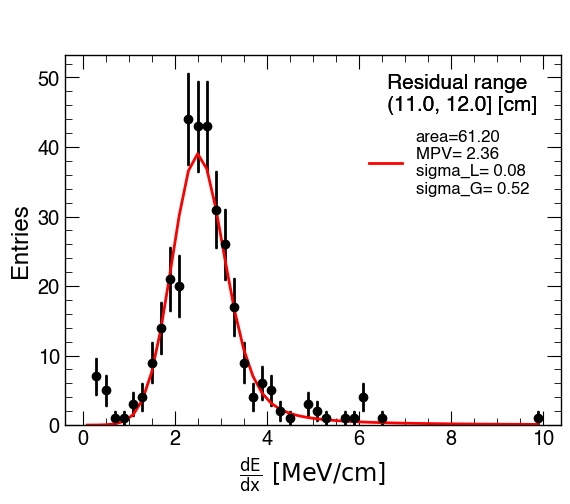

80.25000478327303
[62.53066106  2.24465312  0.10247726  0.45269027]


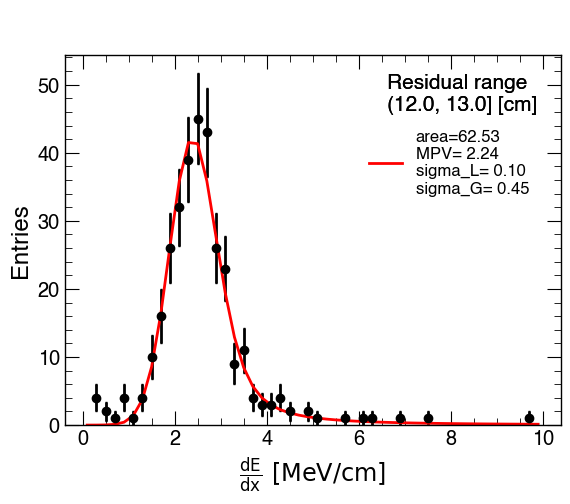

83.7500049918893
[62.32043635  2.28103131  0.09801165  0.39572424]


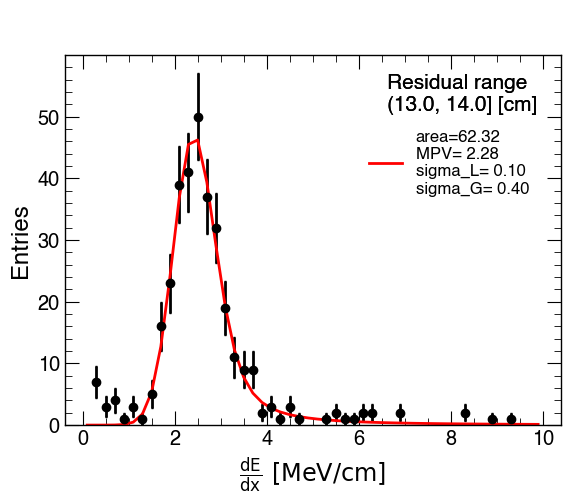

86.00000512599975
[67.8925374   2.23623428  0.10448738  0.5271159 ]


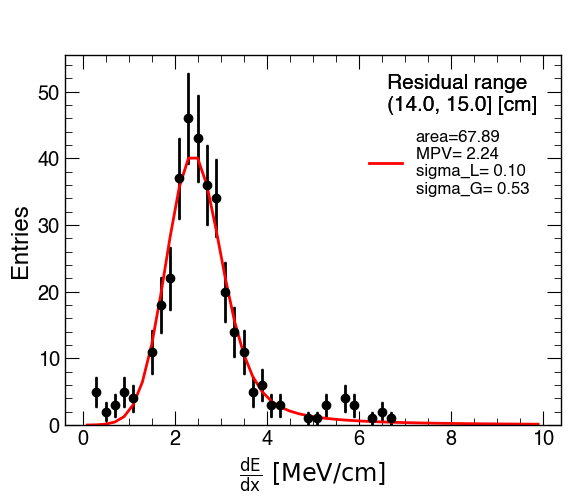

85.50000509619744
[65.53609465  2.17443948  0.1201392   0.41914727]


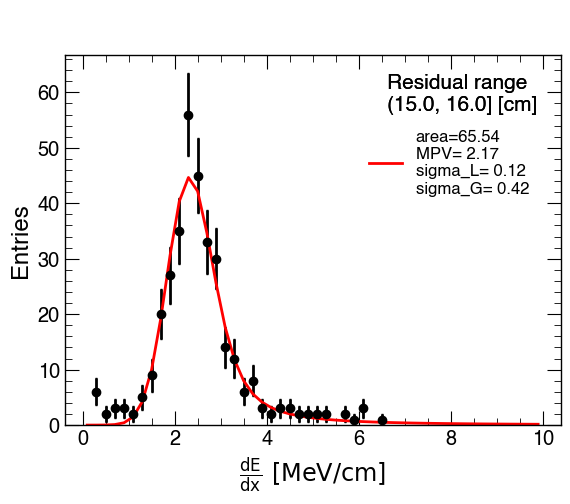

82.00000488758117
[62.20976982  2.12672544  0.1241165   0.38781565]


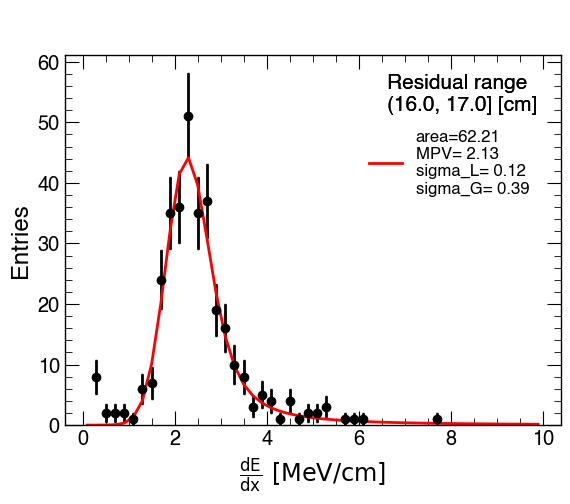

83.7500049918893
[63.66502983  2.10413829  0.1095647   0.43841515]


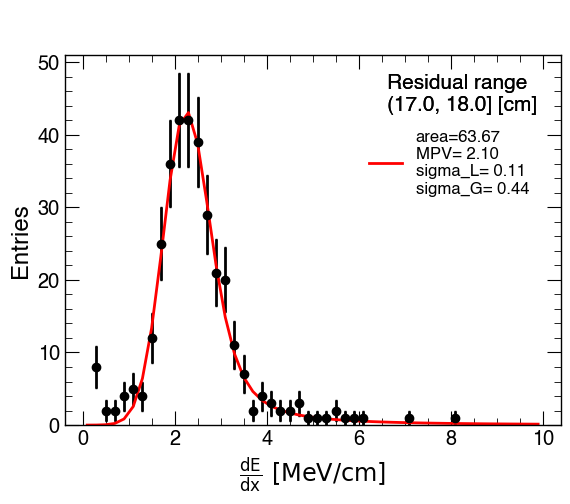

83.7500049918893
[65.20827459  2.09095773  0.10414299  0.39078489]


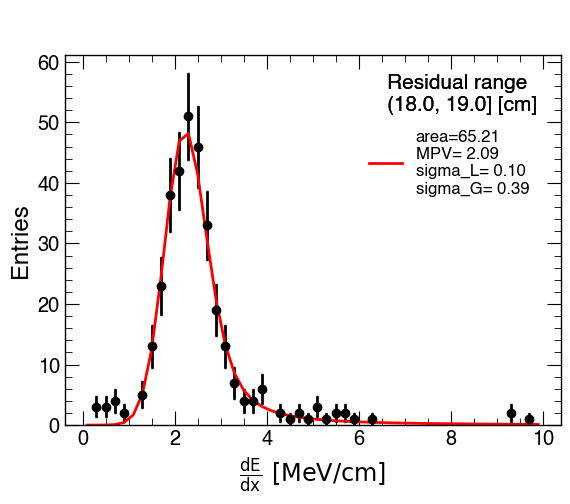

84.5000050365928
[63.04149181  2.05769957  0.10654179  0.36023161]


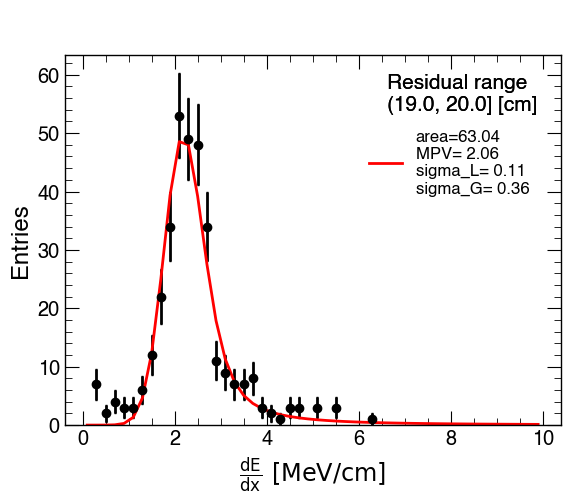

81.75000487268001
[62.11646268  2.00658114  0.10389402  0.37357948]


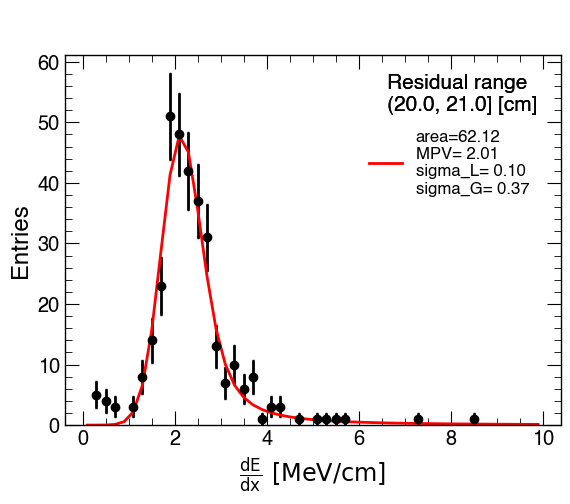

91.000005424023
[68.71223901  2.03524708  0.10165433  0.36433704]


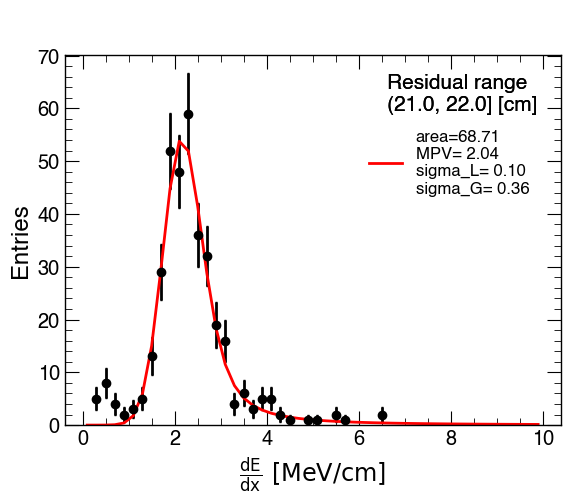

80.5000047981742
[60.15446109  2.01387959  0.11804387  0.30929096]


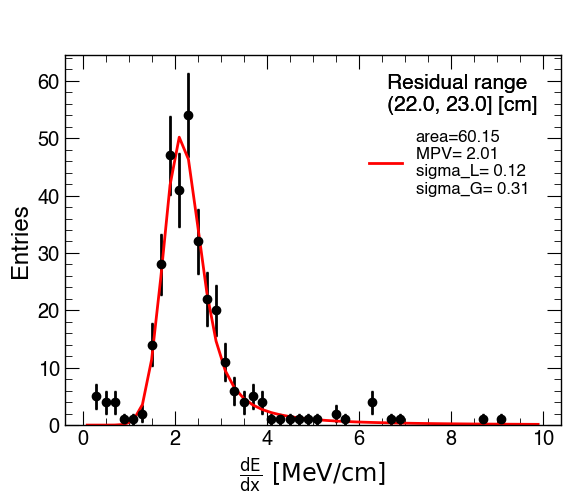

82.50000491738349
[60.78583098  2.06068647  0.07350348  0.33192556]


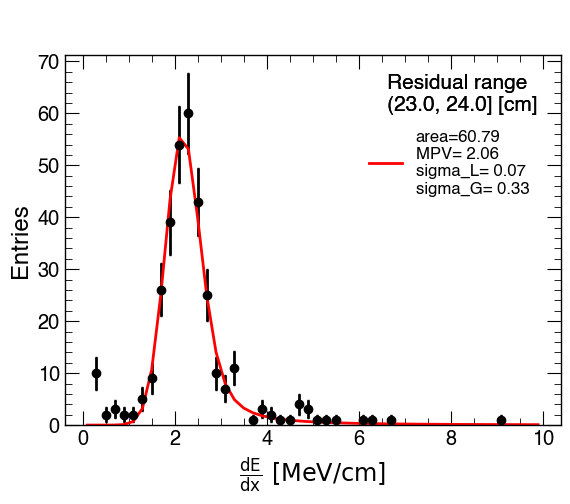

83.25000496208699
[62.48205678  1.95587159  0.09104636  0.3376655 ]


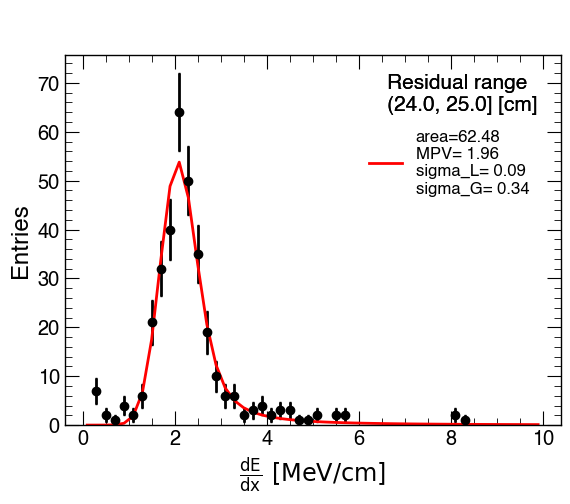

In [34]:
rr_vs_dedx_langau(hit0_sel_df, "plane0_", "")